# Depencency parsing
(парсинг зависимостей)

## Что это?

* наша цель -- представить предложение естественного языка в виде дерева
* слова предложения -- вершины; *зависимости (dependencies)* между ними -- рёбра
* зависимости могут быть разными: например, субъект глагола, объект глагола, прилагательное-модификатор, и так далее

## Формат

Существует несколько форматов записи деревьев зависимостей, но самый популярный и общеиспользуемый -- [CoNLL-U](http://universaldependencies.org/format.html).<br/>
Как это выглядит (пример из [русского Universal Dependency трибанка](https://github.com/UniversalDependencies/UD_Russian-SynTagRus)):

In [54]:
my_example = """
# sent_id = 2003Armeniya.xml_138
# text = Перспективы развития сферы высоких технологий.
1	Перспективы	перспектива	NOUN	_	Animacy=Inan|Case=Nom|Gender=Fem|Number=Plur	0	ROOT	0:root	_
2	развития	развитие	NOUN	_	Animacy=Inan|Case=Gen|Gender=Neut|Number=Sing	1	nmod	1:nmod	_
3	сферы	сфера	NOUN	_	Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing	2	nmod	2:nmod	_
4	высоких	высокий	ADJ	_	Case=Gen|Degree=Pos|Number=Plur	5	amod	5:amod	_
5	технологий	технология	NOUN	_	Animacy=Inan|Case=Gen|Gender=Fem|Number=Plur	3	nmod	3:nmod	SpaceAfter=No
6	.	.	PUNCT	_	_	1	punct	1:punct	_
"""

Комментарии + таблица c 9 колонками (разделители табы):
* ID
* FORM: токен
* LEMMA: начальная форма
* UPOS: универсальная часть речи
* XPOS: лингво-специфичная часть речи
* FEATS: морфологическая информация: падеж, род, число etc
* HEAD: id ролителя
* DEPREL: тип зависимости, то есть отношение к токену-родителю
* DEPS: альтернативный подграф (не будем углубляться :))
* MISC: всё остальное

Отсутствующие данные представляются с помощью `_`. Больше подробностей про формат -- в [официальной документаци](http://universaldependencies.org/format.html).<br>
User-friendly визуализация: ![2003Armeniya.xml_138](rus_tree.png)

Отрытый инструмент для визуализации, ручной разметки и конвертации в другие форматы: UD Annotatrix. [Online-интерфейс](https://maryszmary.github.io/ud-annotatrix/standalone/annotator.html), [репозиторий](https://github.com/jonorthwash/ud-annotatrix).

Трибанк -- много таких предложений. Обычно они разделяются двумя переносами строки.
### Как считывать данные в питоне

Используем библиотеку [conllu](https://github.com/EmilStenstrom/conllu).

In [55]:
# !pip3 install conllu
from conllu import parse

In [56]:
help(parse)

Help on function parse in module conllu:

parse(data: str, fields: Optional[Sequence[str]] = None, field_parsers: Dict[str, Callable[[List[str], int], Any]] = None, metadata_parsers: Optional[Dict[str, Callable[[str, Optional[str]], Any]]] = None) -> conllu.models.SentenceList



In [57]:
sentences = parse(my_example)
sentence = sentences[0]
sentence[0]

{'id': 1,
 'form': 'Перспективы',
 'lemma': 'перспектива',
 'upos': 'NOUN',
 'xpos': None,
 'feats': {'Animacy': 'Inan',
  'Case': 'Nom',
  'Gender': 'Fem',
  'Number': 'Plur'},
 'head': 0,
 'deprel': 'ROOT',
 'deps': [('root', 0)],
 'misc': None}

In [58]:
sentence[-1]

{'id': 6,
 'form': '.',
 'lemma': '.',
 'upos': 'PUNCT',
 'xpos': None,
 'feats': None,
 'head': 1,
 'deprel': 'punct',
 'deps': [('punct', 1)],
 'misc': None}

## Визуализация

В nltk есть DependencyGraph, который умеет рисовать деревья (и ещё многое другое). Для того, чтобы визуализация работала корректно, ему нужна зависимость: graphviz.

```
sudo apt-get install graphviz
pip3 install graphviz
```

In [59]:
from nltk import DependencyGraph

В отличие от `conllu`, `DependencyGraph` не справляется с комментариями, поэтому придётся их убрать. Кроме того ему обязательно нужен `deprel` *ROOT* в верхнем регистре, иначе он не находит корень.

In [60]:
sents = []
for sent in my_example.split('\n\n'):
    # убираем коменты
    sent = '\n'.join([line for line in sent.split('\n') if not line.startswith('#')])
    # заменяем deprel для root
    sent = sent.replace('\troot\t', '\tROOT\t')
    sents.append(sent)

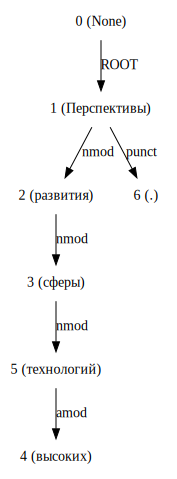

In [61]:
graph = DependencyGraph(tree_str=sents[0])
graph

In [62]:
tree = graph.tree()
print(tree.pretty_print())

    Перспективы           
  _______|__________       
 |               развития 
 |                  |      
 |                сферы   
 |                  |      
 |              технологий
 |                  |      
 .               высоких  

None


In [219]:
def parse_to_graph(row_text):
  lines = row_text.split('\n')
  lines = [i.replace('\troot\t', '\tROOT\t') for i in lines if not i.startswith('#') and i]
  return DependencyGraph(tree_str='\n'.join(lines))

## UDPipe

Есть разные инструменты для парсинга зависимостей. Сегодня мы будем работать с [UDPipe](http://ufal.mff.cuni.cz/udpipe). UDPipe умеет парсить текст с помощью готовых моделей (которые можно скачать [здесь](https://github.com/jwijffels/udpipe.models.ud.2.0/tree/master/inst/udpipe-ud-2.0-170801)) и обучать модели на своих трибанках.

Собственно, в UDPipe есть три вида моделей:
* токенизатор (разделить предложение не токены, сделать заготовку для CoNLL-U)
* тэггер (разметить части речи)
* сам парсер (проставить каждому токену `head` и `deprel`)

Мы сегодня не будем обучать новых моделей (это слишком долго), а используем готовую модель для русского.

### The Python binding

У udpipe есть питоновская обвязка. Она довольно [плохо задокументирована](https://pypi.org/project/ufal.udpipe/), но зато можно использовать прямо в питоне :)

In [63]:
# !pip3 install ufal.udpipe
from ufal.udpipe import Model, Pipeline

In [13]:
# !git clone https://github.com/jwijffels/udpipe.models.ud.2.0.git

Cloning into 'udpipe.models.ud.2.0'...
remote: Enumerating objects: 87, done.
remote: Total 87 (delta 0), reused 0 (delta 0), pack-reused 87
Unpacking objects: 100% (87/87), 897.07 MiB | 18.43 MiB/s, done.
Updating files: 100% (78/78), done.


In [64]:
model = Model.load("udpipe.models.ud.2.0/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe") # path to the model

In [65]:
# если успех, должно быть так (model != None)
model

<Swig Object of type 'model *' at 0x7fa3d3ec26b0>

In [66]:
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')
example = "Если бы мне платили каждый раз. Каждый раз, когда я думаю о тебе."
parsed = pipeline.process(example)
print(parsed)

# newdoc
# newpar
# sent_id = 1
# text = Если бы мне платили каждый раз.
1	Если	ЕСЛИ	SCONJ	IN	_	4	mark	_	_
2	бы	БЫ	PART	RP	_	4	discourse	_	_
3	мне	Я	PRON	PRP	Case=Dat|Number=Sing|Person=1	4	iobj	_	_
4	платили	ПЛАТИТЬ	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin	0	root	_	_
5	каждый	КАЖДЫЙ	DET	DT	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	6	amod	_	_
6	раз	РАЗ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	4	advmod	_	SpaceAfter=No
7	.	.	PUNCT	.	_	4	punct	_	_

# sent_id = 2
# text = Каждый раз, когда я думаю о тебе.
1	Каждый	КАЖДЫЙ	DET	DT	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	2	amod	_	_
2	раз	РАЗ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	6	advmod	_	SpaceAfter=No
3	,	,	PUNCT	,	_	6	punct	_	_
4	когда	КОГДА	ADV	WRB	_	6	advmod	_	_
5	я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	6	nsubj	_	_
6	думаю	дУМАТЬ	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin	0	root	_	_
7	о	О	ADP	IN	_	8	case	_	_
8	тебе	ТЫ	PRON	PRP	Case=Dat|Number=

Как видим, UDPipe и токенизировал, и лематизировал текст, сделал POS-tagging и, собственно, синтаксический парсинг.

### Command line interface

Но с обвязкой бывают проблемы, и вообще довольно удобно пользоваться прекомпилированной утилитой `udpipe` из шелла. Она скачивается [здесь](https://github.com/ufal/udpipe/releases/tag/v1.2.0): (надеюсь, вы уже скачали всё заранее).<br>Внутри бинарники для всех популярных ОС, выбираем свою. У меня путь к бинарнику такой: `~/Documents/udpipe-1.2.0-bin/bin-linux64`.

Синтаксис:

In [28]:
!wget https://github.com/ufal/udpipe/releases/download/v1.2.0/udpipe-1.2.0-bin.zip
!unzip udpipe-1.2.0-bin.zip

In [32]:
!udpipe-1.2.0-bin/bin-linux64/udpipe

Usage: udpipe-1.2.0-bin/bin-linux64/udpipe [running_opts] model_file [input_files]
       udpipe-1.2.0-bin/bin-linux64/udpipe --train [training_opts] model_file [input_files]
       udpipe-1.2.0-bin/bin-linux64/udpipe --detokenize [detokenize_opts] raw_text_file [input_files]
Running opts: --accuracy (measure accuracy only)
              --input=[conllu|generic_tokenizer|horizontal|vertical]
              --immediate (process sentences immediately during loading)
              --outfile=output file template
              --output=[conllu|epe|matxin|horizontal|plaintext|vertical]
              --tokenize (perform tokenization)
              --tokenizer=tokenizer options, implies --tokenize
              --tag (perform tagging)
              --tagger=tagger options, implies --tag
              --parse (perform parsing)
              --parser=parser options, implies --parse
Training opts: --method=[morphodita_parsito] which method to use
               --heldout=heldout data file name
   

Нас сегодня будет интересовать только парсинг, так что типичная команда будет выглядеть так:

In [67]:
with open('example.txt', 'w') as f:
    f.write(example)

! udpipe-1.2.0-bin/bin-linux64/udpipe --tokenize --tag --parse udpipe.models.ud.2.0/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe example.txt > parsed_example.conllu
! cat parsed_example.conllu

Loading UDPipe model: done.
# newdoc id = example.txt
# newpar
# sent_id = 1
# text = Если бы мне платили каждый раз.
1	Если	ЕСЛИ	SCONJ	IN	_	4	mark	_	_
2	бы	БЫ	PART	RP	_	4	discourse	_	_
3	мне	Я	PRON	PRP	Case=Dat|Number=Sing|Person=1	4	iobj	_	_
4	платили	ПЛАТИТЬ	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Plur|Tense=Past|VerbForm=Fin	0	root	_	_
5	каждый	КАЖДЫЙ	DET	DT	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	6	amod	_	_
6	раз	РАЗ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	4	advmod	_	SpaceAfter=No
7	.	.	PUNCT	.	_	4	punct	_	_

# sent_id = 2
# text = Каждый раз, когда я думаю о тебе.
1	Каждый	КАЖДЫЙ	DET	DT	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	2	amod	_	_
2	раз	РАЗ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	6	advmod	_	SpaceAfter=No
3	,	,	PUNCT	,	_	6	punct	_	_
4	когда	КОГДА	ADV	WRB	_	6	advmod	_	_
5	я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	6	nsubj	_	_
6	думаю	дУМАТЬ	VERB	VBC	Aspect=Imp|Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin	0	root	_	_
7	о	О	ADP	IN	_	8

(Ну а потом снова считываем проанализированные предложения питоном).

Вот два способа работать с UDPipe. Choose your fighter! 

## Главред

Главред -- [сервис](https://glvrd.ru/) для корекции стиля текста. Кроме интерфейса, у него есть [API](https://glvrd.ru/api/)!<br>
На этом семинаре мы имплементируем несколько функций, делающих нечто похожее, на основе синтаксиса.

Возьмём простой пример: предложение, перегруженное однородными членами.

# newdoc
# newpar
# sent_id = 1
# text = Я пришла, включила компьютер, открыла почту, прочитала письмо, налила чай.
1	Я	Я	PRON	PRP	Case=Nom|Number=Sing|Person=1	2	nsubj	_	_
2	пришла	приИДТИ	VERB	VBC	Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	0	root	_	SpaceAfter=No
3	,	,	PUNCT	,	_	4	punct	_	_
4	включила	включила	VERB	VBC	Aspect=Perf|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	2	conj	_	_
5	компьютер	компьютер	NOUN	NN	Animacy=Anim|Case=Gen|Gender=Fem|Number=Plur	4	obj	_	SpaceAfter=No
6	,	,	PUNCT	,	_	7	punct	_	_
7	открыла	открЫТЬ	VERB	VBC	Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	4	conj	_	_
8	почту	почТОТ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing	7	obj	_	SpaceAfter=No
9	,	,	PUNCT	,	_	10	punct	_	_
10	прочитала	прочитала	VERB	VBC	Aspect=Imp|Gender=Fem|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	2	conj	_	_
11	письмо	ПИСЬМО	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing	10	obj	_	SpaceAfter=No
12	,	,	PUNCT	,	_	13	p

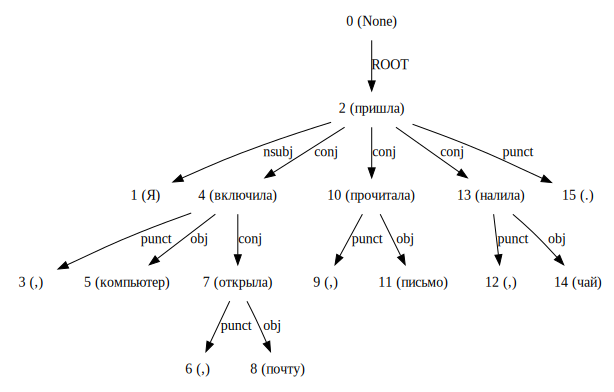

In [176]:
conj = 'Я пришла, включила компьютер, открыла почту, прочитала письмо, налила чай.'
conll_conj = pipeline.process(conj)
print(conll_conj)
parse_to_graph(conll_conj)

В таком случае очень много частей предложения, соединённых связью `conj` -- ей обозначаются однородные члены предложения. В таком случае можно просто посчитать количество таких связей:

In [197]:
def count_conj(sentence):
    # your code here
    conll_sem = pipeline.process(sentence)
    conll_sem = [i.split('\t') for i in conll_sem.split('\n') if not i.startswith('#') and i]
    conj_count = len([i for i in conll_sem if i[7] == 'conj'])
    return conj_count
    
f'кол-во однородных членов: {count_conj(conj)}'

'кол-во однородных членов: 4'

Ещё одна проблема, на которую обращают внимание в Главреде -- [парцелляция](http://maximilyahov.ru/blog/all/parcel/). Часто она делает предложения менее читаемыми.

По словам Главреда,
> Признак парцелляции — предложение синтаксически неполное и само по себе не имеет смысла.

Например, в предложении нет субъекта:

# newdoc
# newpar
# sent_id = 1
# text = Выключил компьютер и заснул.
1	Выключил	Выключил	VERB	VBC	Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	0	root	_	_
2	компьютер	компьютер	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing	1	obj	_	_
3	и	И	CCONJ	CC	_	4	cc	_	_
4	заснул	заснУЛ	VERB	VBC	Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin	1	conj	_	SpaceAfter=No
5	.	.	PUNCT	.	_	1	punct	_	SpacesAfter=\n


['1\tВыключил\tВыключил\tVERB\tVBC\tAspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin\t0\tROOT\t_\t_', '2\tкомпьютер\tкомпьютер\tNOUN\tNN\tAnimacy=Inan|Case=Acc|Gender=Masc|Number=Sing\t1\tobj\t_\t_', '3\tи\tИ\tCCONJ\tCC\t_\t4\tcc\t_\t_', '4\tзаснул\tзаснУЛ\tVERB\tVBC\tAspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin\t1\tconj\t_\tSpaceAfter=No', '5\t.\t.\tPUNCT\t.\t_\t1\tpunct\t_\tSpacesAfter=\\n']


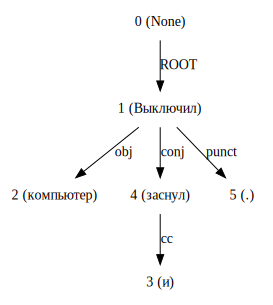

In [179]:
ex = 'Выключил компьютер и заснул.'
conll_ex = pipeline.process(ex)
print(conll_ex)
parse_to_graph(conll_ex)

Или вообще что-то странное:

# newdoc
# newpar
# sent_id = 1
# text = А броско, шикарно и выделяля бы вас из толпы
1	А	А	CCONJ	CC	_	2	cc:preconj	_	_
2	броско	броско	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing	0	root	_	SpaceAfter=No
3	,	,	PUNCT	,	_	4	punct	_	_
4	шикарно	шикаРНО	ADV	RB	_	2	conj	_	_
5	и	И	CCONJ	CC	_	6	cc	_	_
6	выделяля	выделяля	ADP	IN	_	8	case	_	_
7	бы	БЫ	PART	RP	_	8	discourse	_	_
8	вас	ВЫ	PRON	PRP	Case=Acc|Number=Plur|Person=2	2	nmod	_	_
9	из	ИЗ	ADP	IN	_	10	case	_	_
10	толпы	толпы	NOUN	NN	Animacy=Inan|Case=Gen|Gender=Fem|Number=Sing	2	nmod	_	SpacesAfter=\n


['1\tА\tА\tCCONJ\tCC\t_\t2\tcc:preconj\t_\t_', '2\tброско\tброско\tNOUN\tNN\tAnimacy=Inan|Case=Acc|Gender=Neut|Number=Sing\t0\tROOT\t_\tSpaceAfter=No', '3\t,\t,\tPUNCT\t,\t_\t4\tpunct\t_\t_', '4\tшикарно\tшикаРНО\tADV\tRB\t_\t2\tconj\t_\t_', '5\tи\tИ\tCCONJ\tCC\t_\t6\tcc\t_\t_', '6\tвыделяля\tвыделяля\tADP\tIN\t_\t8\tcase\t_\t_', '7\tбы\tБЫ\tPART\tRP\t_\t8\tdiscourse\t_\t_', '8\tвас\tВЫ\tPRON\tPRP\tCase=Acc|Number=Plur|Person=2\t2\tnmo

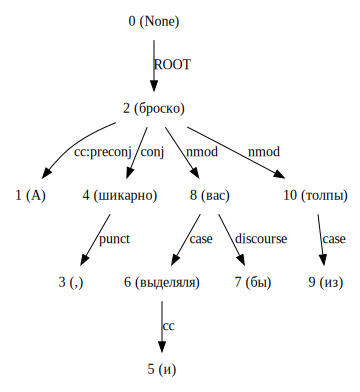

In [180]:
ex = 'А броско, шикарно и выделяля бы вас из толпы'
conll_ex = pipeline.process(ex)
print(conll_ex)
parse_to_graph(conll_ex)

Напишите функцию, которая помогает обнаруживать парцелляцию, опираясь на то, что предложение неполное:

In [164]:
import pandas as pd
def parse_to_dataframe(sentence):
    conll_sent = pipeline.process(sentence)
    return pd.DataFrame([i.split('\t') for i in conll_sent.split('\n') if not i.startswith('#') and i])

In [181]:
def is_parcelling(sentence):
    conll_sent = pipeline.process(sentence)
    lines = [i.split('\t') for i in conll_sent.split('\n') if not i.startswith('#') and i]
    root_number = [i for i in lines if i[7]=='root'][0][0]
    root_deps = [i[7] for i in lines if i[6]==root_number]
    for i in lines:
        if (i[7]=='root' and i[3]!='VERB') or \
           ('nsubj' not in root_deps):
          return True
    return False

In [182]:
is_parcelling('Я пришла, включила компьютер, открыла почту, прочитала письмо, налила чай.')

False

In [183]:
is_parcelling('Выключил компьютер и заснул.')

True

In [184]:
is_parcelling('А броско, шикарно и выделяля бы вас из толпы')

True

А теперь давайте усложним критерий на однородные члены: проверим, не состоит ли предложение из большого числа однородных предложений. Для этого проверим, являются ли однородные члены глаголами.

In [192]:
def count_conj_verb(sentence):
    # your code here
    conll_sem = pipeline.process(sentence)
    conll_sem = [i.split('\t') for i in conll_sem.split('\n') if not i.startswith('#') and i]
    conj_verb_count = len([i for i in conll_sem if (i[3]=='VERB') and ((i[7] == 'conj') or (i[7]=='root'))])
    print(f'кол-во однородных членов: {conj_verb_count}')
    
count_conj_verb(conj)

кол-во однородных членов: 5


Придумайте метрику для оценки качества предложений на основе написаных функций. Напишите функцию-оцениватель. Пусть она принимает на вход предложение, а возвращает оценку от 1 до 10.

In [204]:
def get_score(sentence):
    # your code here
    parc_score = 1
    if is_parcelling(sentence):
      parc_score = 0
    conj_count = count_conj(sentence)
    conj_score = 1
    if conj_count > 7:
      conj_score = 0
    elif conj_count > 5:
      conj_score = 0.3
    elif conj_count > 4:
      conj_score = 0.4
    elif conj_count > 3:
      conj_score = 0.7
    elif conj_count > 2:
      conj_score = 0.85
    return max(1, 5*parc_score + int(5*conj_score) )

print('sentence:', conj)
print('my score:', get_score(conj))
print()

print('sentence:', ex)
print('my score:', get_score(ex))
print()

sentence: Я пришла, включила компьютер, открыла почту, прочитала письмо, налила чай.
my score: 8

sentence: А броско, шикарно и выделяля бы вас из толпы
my score: 5



Если осталось время, придумайте и напишите свою функцию, которая помогала бы оценивать качество текста. Добавьте её в метрику.

In [208]:
import numpy as np
def text_score(text):
  lines = text.split('\n')
  score_list = [get_score(i) for i in lines]
  return np.mean(score_list)

text_score('Мотоци́кл (фр. motocycle, от лат. mōtor — приводящий в движение и греч. κύκλος — круг, колесо) — как правило, двухколёсное (реже — трёхколёсное) транспортное средство с двигателем (внутреннего сгорания, электрическим, пневматическим), главными отличительными чертами которого являются вертикальная посадка водителя (мотоциклиста), наличие боковых ножных упоров (площадок, подножек) и прямое (безредукторное) управление передним поворотным колесом[1].\n Самый первый мотоцикл был придуман инженером Готтлибом Даймлером в 1885 и назывался он Daimler Reitwagen. \n Классические мотоциклы включают в себя двухколёсные, двухколёсные с боковой коляской, и трёхколёсные; в начале XXI века стали набирать популярность квадроциклы. Мотоциклы также подразделяются по своей конструкции и размерам: мопеды, мокики (имеют небольшой размер двигателя, как правило до 50 см³) мотороллеры или скутеры (закрытый пластиком двигатель, расположенный под сиденьем водителя и площадки для ног), и собственно мотоциклы различных типов: классические, крузеры, туреры, спортивные, шоссейные, кроссовые, эндуро, чопперы.')

3.6666666666666665

## SVO-triples

С помощью синтекстического парсинга можно извлекать из предложений тройки субъект-объект-глагол, которые можно использовать для извлечения информации из текста.  

In [221]:
sent = """1	Собянин	_	NOUN	_	Animacy=Anim|Case=Nom|Gender=Masc|Number=Sing|fPOS=NOUN++	2	nsubj	_	_
2	открыл	_	VERB	_	Aspect=Perf|Gender=Masc|Mood=Ind|Number=Sing|Tense=Past|VerbForm=Fin|Voice=Act|fPOS=VERB++	0	ROOT	_	_
3	новый	_	ADJ	_	Animacy=Inan|Case=Acc|Degree=Pos|Gender=Masc|Number=Sing|fPOS=ADJ++	4	amod	_	_
4	парк	_	NOUN	_	Animacy=Inan|Case=Acc|Gender=Masc|Number=Sing|fPOS=NOUN++	2	dobj	_	_
5	и	_	CONJ	_	fPOS=CONJ++	4	cc	_	_
6	детскую	_	ADJ	_	Case=Acc|Degree=Pos|Gender=Fem|Number=Sing|fPOS=ADJ++	7	amod	_	_
7	площадку	_	NOUN	_	Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing|fPOS=NOUN++	4	conj	_	_
8	.	_	PUNCT	.	fPOS=PUNCT++.	2	punct	_	_"""

Тройки слово-слово-связь:

In [222]:
graph = DependencyGraph(tree_str=sent)
list(graph.triples())

[(('открыл', 'VERB'), 'nsubj', ('Собянин', 'NOUN')),
 (('открыл', 'VERB'), 'dobj', ('парк', 'NOUN')),
 (('парк', 'NOUN'), 'amod', ('новый', 'ADJ')),
 (('парк', 'NOUN'), 'cc', ('и', 'CONJ')),
 (('парк', 'NOUN'), 'conj', ('площадку', 'NOUN')),
 (('площадку', 'NOUN'), 'amod', ('детскую', 'ADJ')),
 (('открыл', 'VERB'), 'punct', ('.', 'PUNCT'))]

Тройки субьект-объект-глагол:

In [224]:
def get_sov(sent):
    graph = DependencyGraph(tree_str=sent)
    sov = {}
    for triple in graph.triples():
        if triple:
            if triple[0][1] == 'VERB':
                sov[triple[0][0]] = {'subj':'','obj':''}
    for triple in graph.triples():
        if triple:
            if triple[1] == 'nsubj':
                if triple[0][1] == 'VERB':
                    sov[triple[0][0]]['subj']  = triple[2][0]
            if triple[1] == 'dobj':
                if triple[0][1] == 'VERB':
                    sov[triple[0][0]]['obj'] = triple[2][0]
    return sov

sov = get_sov(sent)
print(sov)

{'открыл': {'subj': 'Собянин', 'obj': 'парк'}}


Измените код выше так, чтобы учитывались:
    1. Однородные члены предложения 
        * (парк, площадка), (Германия, Щвейцария)
    2. Сложные сказуемые 
        * (начнет продавать), (запретил провозить)
    3. Непрямые объекты
        * (едет, Польшу), (спел, скандале)

In [228]:
graph = DependencyGraph(tree_str=sent)
list(graph.triples())

[(('открыл', 'VERB'), 'nsubj', ('Собянин', 'NOUN')),
 (('открыл', 'VERB'), 'dobj', ('парк', 'NOUN')),
 (('парк', 'NOUN'), 'amod', ('новый', 'ADJ')),
 (('парк', 'NOUN'), 'cc', ('и', 'CONJ')),
 (('парк', 'NOUN'), 'conj', ('площадку', 'NOUN')),
 (('площадку', 'NOUN'), 'amod', ('детскую', 'ADJ')),
 (('открыл', 'VERB'), 'punct', ('.', 'PUNCT'))]

In [243]:
def get_sov(sent):
    graph = DependencyGraph(tree_str=sent)
    obj_list = [] #<-
    sov = {}
    for triple in graph.triples():
        if triple:
            if triple[0][1] == 'VERB':
                sov[triple[0][0]] = {'subj':'','obj':obj_list}
    for triple in graph.triples():
        if triple:
            if triple[1] == 'nsubj':
                if triple[0][1] == 'VERB':
                    sov[triple[0][0]]['subj']  = triple[2][0]
            if triple[1] in ['dobj', 'conj']:                    #<-
                if triple[0][1] in ['VERB', 'NOUN']:             #<-
                    obj_list.append(triple[2][0])                #<-
                    sov[list(sov.keys())[0]]['obj'] = obj_list   #<-
    return sov

sov = get_sov(sent)
print(sov)

{'открыл': {'subj': 'Собянин', 'obj': ['парк', 'площадку']}}
